[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [9]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break bEa6KXcZo6gop69GJ1U6jT7Z

crunch-cli, version 7.5.0
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_notebook()`
2. Execute the cells with your code
3. Run a test: `crunch.test()`
4. Download and submit your code to t

In [10]:
import crunch
crunch = crunch.load_notebook()


loaded inline runner with module: <module '__main__'>

cli version: 7.5.0
available ram: 12.67 gb
available cpu: 2 core
----


In [17]:
import os
print(os.listdir())


['.config', '.crunchdao', 'resources', 'data', 'sample_data']


In [18]:
!find / -type d -name "structural-break" 2>/dev/null | head -n 10


In [11]:
import numpy as np
import pandas as pd
import joblib
import os
import typing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats, signal

# ---------- Feature extraction ----------
def extract_features(df: pd.DataFrame) -> pd.Series:
    pre = df[df["period"] == 0]["value"].values
    post = df[df["period"] == 1]["value"].values

    def safe_stat(x, func, default=0.0):
        try:
            return func(x)
        except Exception:
            return default

    # Rolling stats (window ~ 50 if enough points)
    def rolling_var(x, w=50):
        if len(x) < w:
            return np.var(x)
        return pd.Series(x).rolling(w).var().dropna().mean()

    # FFT energy
    def fft_energy(x):
        if len(x) == 0:
            return 0
        fft_vals = np.abs(np.fft.rfft(x))
        return np.sum(fft_vals**2)

    # Autocorr
    def autocorr(x, lag=1):
        if len(x) <= lag:
            return 0
        return np.corrcoef(x[:-lag], x[lag:])[0,1]

    features = {
        # Basic stats
        "mean_diff": safe_stat(post, np.mean) - safe_stat(pre, np.mean),
        "var_diff": safe_stat(post, np.var) - safe_stat(pre, np.var),
        "median_diff": np.median(post) - np.median(pre),

        # Higher moments
        "skew_diff": safe_stat(post, pd.Series(post).skew) - safe_stat(pre, pd.Series(pre).skew),
        "kurt_diff": safe_stat(post, pd.Series(post).kurt) - safe_stat(pre, pd.Series(pre).kurt),

        # Rolling variance
        "rollvar_diff": rolling_var(post) - rolling_var(pre),

        # Autocorr
        "autocorr_diff": autocorr(post) - autocorr(pre),

        # FFT energy
        "fft_energy_diff": fft_energy(post) - fft_energy(pre),

        # KS test statistic (two-sample distribution test)
        "ks_stat": stats.ks_2samp(pre, post).statistic if len(pre) > 0 and len(post) > 0 else 0,

        # CUSUM (cumulative sum of mean differences)
        "cusum_stat": np.max(np.abs(np.cumsum(post - np.mean(pre)))) if len(post) > 0 else 0,
    }

    return pd.Series(features)


# ---------- Training ----------
def train(X_train: pd.DataFrame, y_train: pd.Series, model_directory_path: str):
    # Build dataset of features for each id
    features_list = []
    for idx, df in X_train.groupby("id"):
        feat = extract_features(df)
        feat["id"] = idx
        features_list.append(feat)
    feature_df = pd.DataFrame(features_list).set_index("id")

    # Align with y_train
    X_feat = feature_df.loc[y_train.index]
    y = y_train.astype(int)

    # Build pipeline: scaling + logistic regression
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    # Train
    model.fit(X_feat, y)

    # Save
    joblib.dump(model, os.path.join(model_directory_path, "model.joblib"))


# ---------- Inference ----------
def infer(X_test: typing.Iterable[pd.DataFrame], model_directory_path: str):
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    yield  # Mark as ready

    for df in X_test:
        feat = extract_features(df).values.reshape(1, -1)
        # Predict probability of structural break (class 1)
        pred = model.predict_proba(feat)[0, 1]
        yield pred


In [12]:
import os
print(os.listdir())


['.config', '.crunchdao', 'resources', 'data', 'sample_data']


In [13]:
crunch.test()


12:31:57 no forbidden library found
12:31:57 
12:31:57 started
12:31:57 running local test
12:31:57 internet access isn't restricted, no check will be done
12:31:57 
12:31:57 starting unstructured loop...
12:31:57 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


12:33:13 executing - command=infer
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [14]:
import pandas as pd
import sklearn.metrics

prediction = pd.read_parquet("data/prediction.parquet")
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

print("Local ROC AUC:", sklearn.metrics.roc_auc_score(target, prediction))


Local ROC AUC: 0.4981220657276995


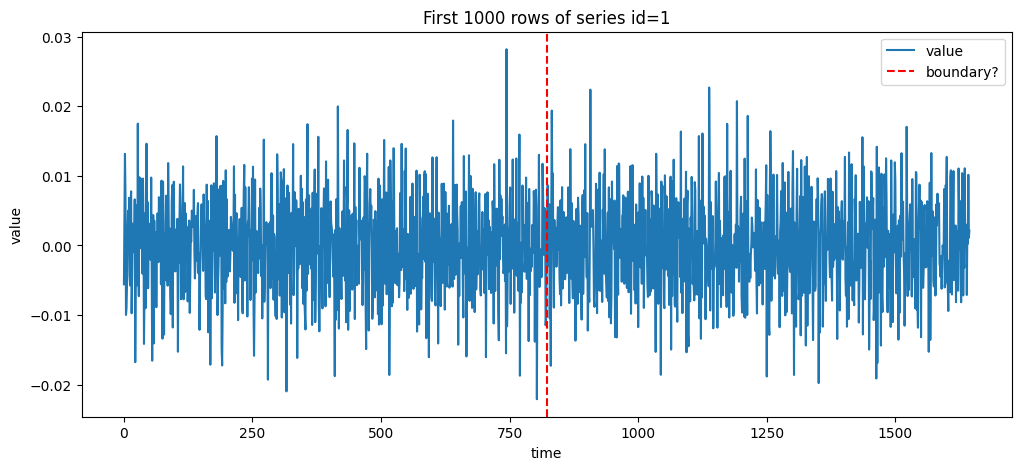

In [25]:
import matplotlib.pyplot as plt

# Select the series with id=0
df_series = X_train.loc[0]

# Take the first 1000 time steps
df_1000 = df_series.head(10000)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_1000.index, df_1000["value"], label="value")
plt.axvline(df_1000.index.max()/2, color="red", linestyle="--", label="boundary?")
plt.title("First 1000 rows of series id=1")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()


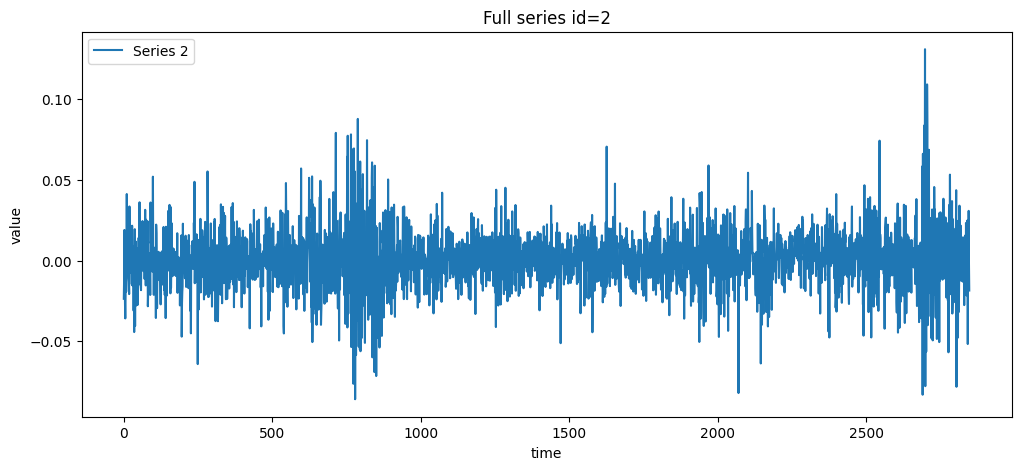

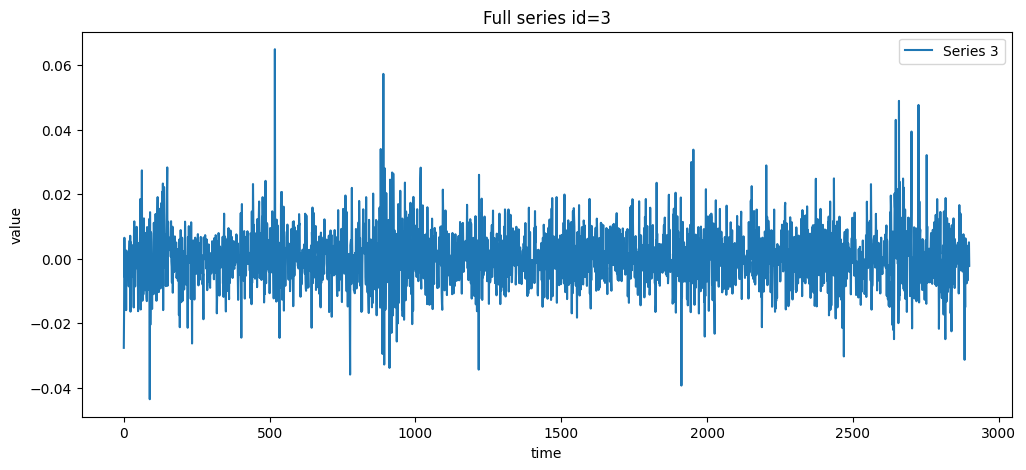

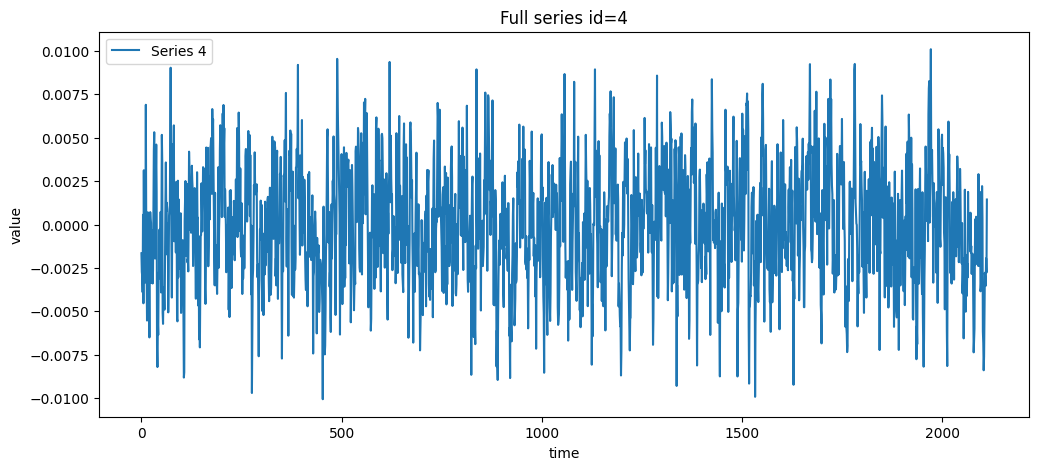

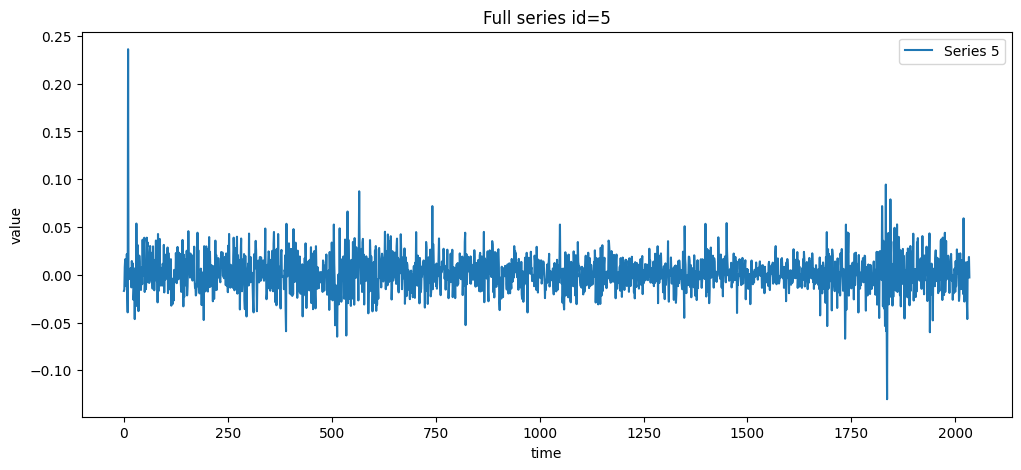

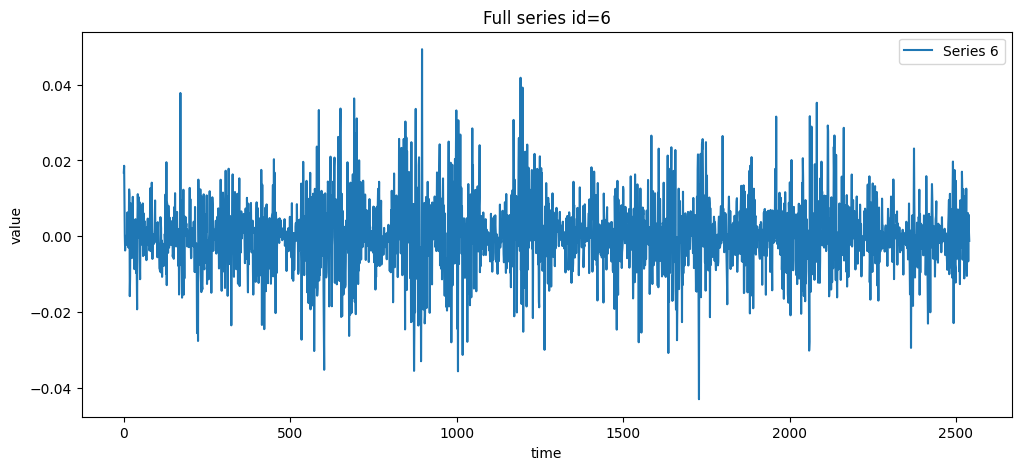

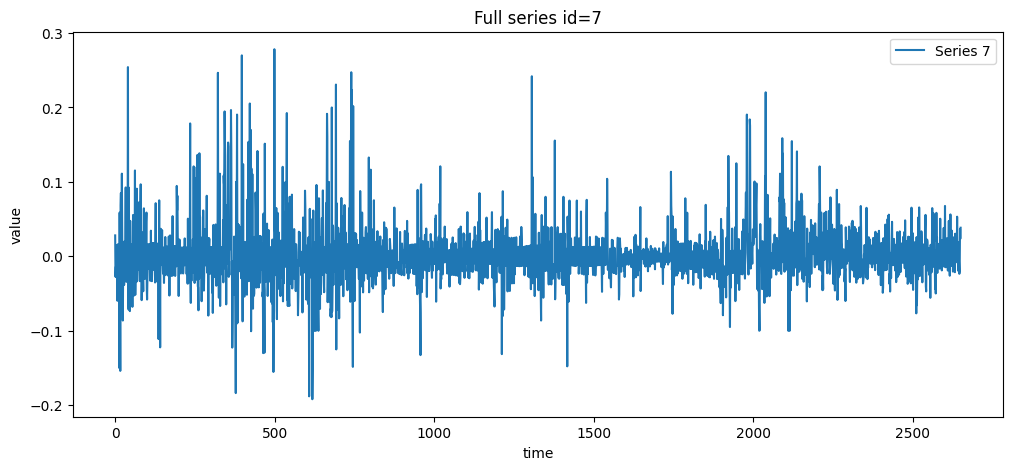

In [26]:
import matplotlib.pyplot as plt

# Loop through series IDs 2 to 7
for sid in range(2, 8):
    df_series = X_train.loc[sid]   # extract series

    plt.figure(figsize=(12,5))
    plt.plot(df_series.index, df_series["value"], label=f"Series {sid}")
    plt.title(f"Full series id={sid}")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.show()


Detected breakpoints for series 0: [1645]


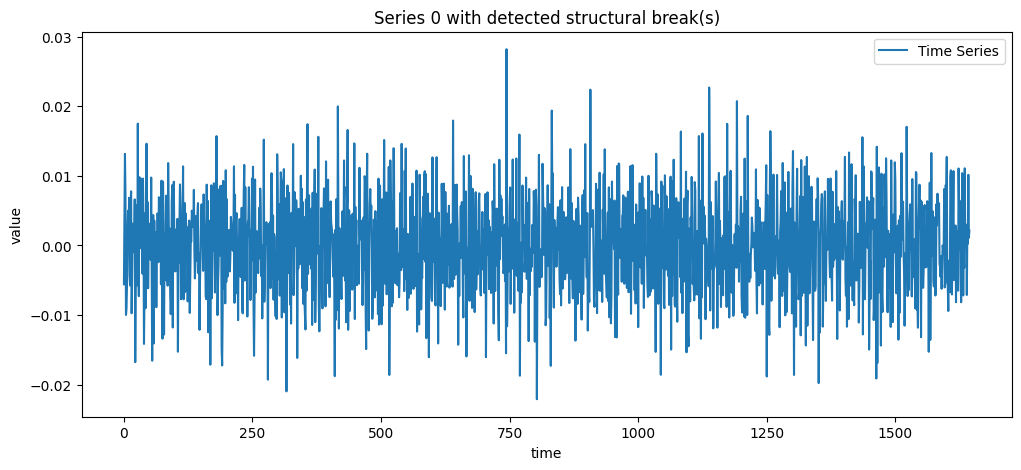

In [30]:
import matplotlib.pyplot as plt
import ruptures as rpt

# Select series 0
df_series = X_train.loc[0]

# Extract signal as numpy array
signal = df_series["value"].values

# Apply ruptures (Pelt with "rbf" cost = detects changes in mean/variance)
model = "rbf"
algo = rpt.Pelt(model=model).fit(signal)

# Detect breakpoints (penalty controls sensitivity; adjust if too many/few)
breaks = algo.predict(pen=3)

print("Detected breakpoints for series 0:", breaks)

# Plot result
plt.figure(figsize=(12, 5))
plt.plot(df_series.index, signal, label="Time Series")
for br in breaks[:-1]:  # skip last index (end of series)
    plt.axvline(br, color="red", linestyle="--", label="Detected Breakpoint")
plt.title("Series 0 with detected structural break(s)")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()


In [28]:
!pip install ruptures


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00


/tmp/ipython-input-1103155163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series["mean"] = df_series["value"].rolling(20).mean()
/tmp/ipython-input-1103155163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_series["std"] = df_series["value"].rolling(20).std()


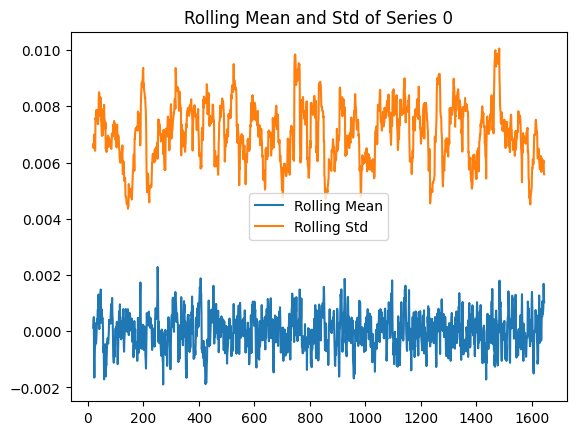

In [31]:
df_series["mean"] = df_series["value"].rolling(20).mean()
df_series["std"] = df_series["value"].rolling(20).std()

plt.plot(df_series.index, df_series["mean"], label="Rolling Mean")
plt.plot(df_series.index, df_series["std"], label="Rolling Std")
plt.legend()
plt.title("Rolling Mean and Std of Series 0")
plt.show()

In [32]:
# Count unique series
num_series = X_train["series_id"].nunique()
print(f"Total unique series in X_train: {num_series}")

KeyError: 'series_id'

In [33]:
print("Columns in X_train:", X_train.columns.tolist())

Columns in X_train: ['value', 'period']


In [34]:
# Each row is a separate series
num_series = len(X_train)
print(f"Total series: {num_series}")

Total series: 23715734


In [36]:
# 🧠 Define the structural break detection function
import ruptures as rpt

def detect_breaks(signal, model="rbf", pen=10):
    algo = rpt.Pelt(model=model).fit(signal)
    breaks = algo.predict(pen=pen)
    return breaks[:-1]  # exclude last index (end of series)

In [37]:
# Sample first N series
N = 1000
sample_df = X_train.iloc[:N]

# Loop through sampled series
series_classification = []

for i in range(N):
    signal = np.array(sample_df.iloc[i]["value"])  # assuming each row is a series
    breaks = detect_breaks(signal, model="rbf", pen=10)
    is_volatile = len(breaks) > 0

    series_classification.append({
        "series_index": i,
        "num_breaks": len(breaks),
        "classification": "volatile" if is_volatile else "stable"
    })

# Summary
summary_df = pd.DataFrame(series_classification)
print(summary_df["classification"].value_counts())

ValueError: A 2-dimensional array must be passed. (Shape was ()).

In [38]:
print(type(X_train.iloc[0]["value"]))
print(X_train.iloc[0]["value"])

<class 'numpy.float64'>
-0.00556447881916989


In [39]:
# 🧠 Define detection function
def detect_breaks(signal, model="rbf", pen=10):
    signal = signal.reshape(-1, 1)  # ensure 2D shape
    algo = rpt.Pelt(model=model).fit(signal)
    breaks = algo.predict(pen=pen)
    return breaks[:-1]  # exclude last index

# 📊 Group by 'period'
grouped = X_train.groupby("period")
print(f"Total unique series: {len(grouped)}")

# 🔍 Sample first N series
N = 1000
series_classification = []

for pid, df_series in list(grouped)[:N]:
    signal = df_series["value"].values
    if len(signal) < 10:
        continue  # skip very short series

    try:
        breaks = detect_breaks(signal, model="rbf", pen=10)
        is_volatile = len(breaks) > 0
    except Exception as e:
        print(f"Error in period {pid}: {e}")
        continue

    series_classification.append({
        "period": pid,
        "num_breaks": len(breaks),
        "classification": "volatile" if is_volatile else "stable"
    })

# 📋 Summary
summary_df = pd.DataFrame(series_classification)
print(summary_df["classification"].value_counts())

Total unique series: 2
Error in period 0: Unable to allocate 1.08 PiB for an array with shape (152584806015960,) and data type float64
Error in period 1: Unable to allocate 142. TiB for an array with shape (19510183808506,) and data type float64


KeyError: 'classification'

In [40]:
group_sizes = X_train.groupby("period").size()
print(group_sizes)

period
0    17469105
1     6246629
dtype: int64


In [41]:
import ruptures as rpt
import numpy as np

def detect_breaks_chunked(signal, chunk_size=5000, model="rbf", pen=10):
    breakpoints = []
    for start in range(0, len(signal), chunk_size):
        end = min(start + chunk_size, len(signal))
        chunk = signal[start:end].reshape(-1, 1)
        if len(chunk) < 10:
            continue
        try:
            algo = rpt.Pelt(model=model).fit(chunk)
            brks = algo.predict(pen=pen)
            # Adjust breakpoints to global index
            breakpoints.extend([start + b for b in brks[:-1]])
        except Exception as e:
            print(f"Chunk {start}-{end} failed: {e}")
            continue
    return breakpoints


In [ ]:
# Select one period (e.g., 0)
df_series = X_train[X_train["period"] == 0]
signal = df_series["value"].values

# Run chunked detection
breaks = detect_breaks_chunked(signal, chunk_size=5000, pen=10)
print(f"Detected {len(breaks)} breakpoints")

# Plot (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_series.index, signal, label="Time Series")
for br in breaks:
    plt.axvline(df_series.index[br], color="red", linestyle="--")
plt.title("Detected Breaks in Period 0 (Chunked)")
plt.legend()
plt.show()

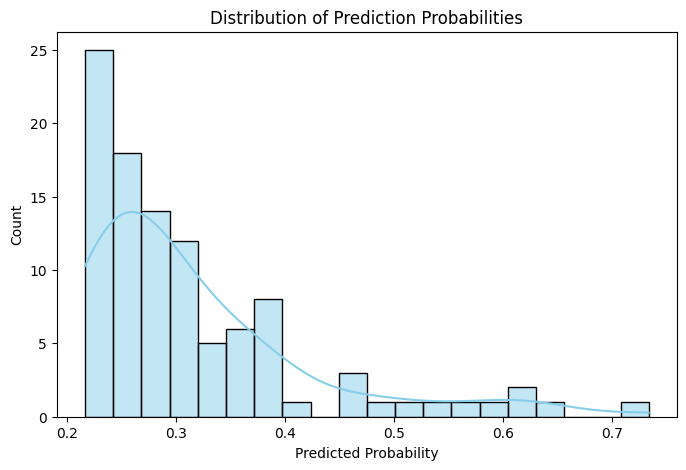

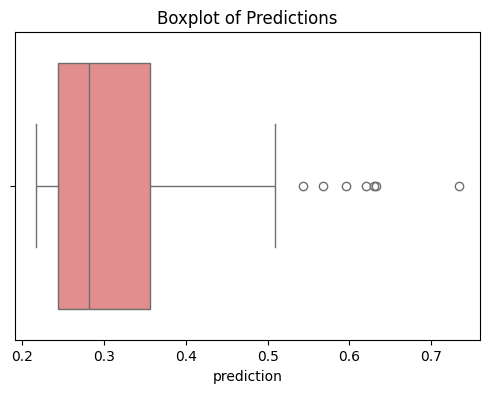

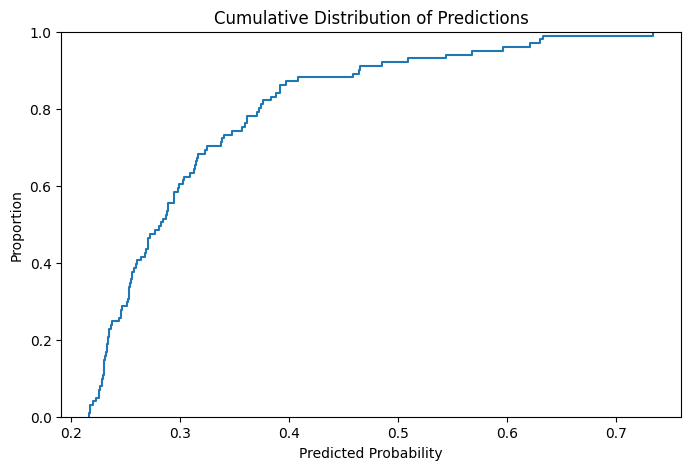

/tmp/ipython-input-135686157.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["predicted_class"], palette="viridis")


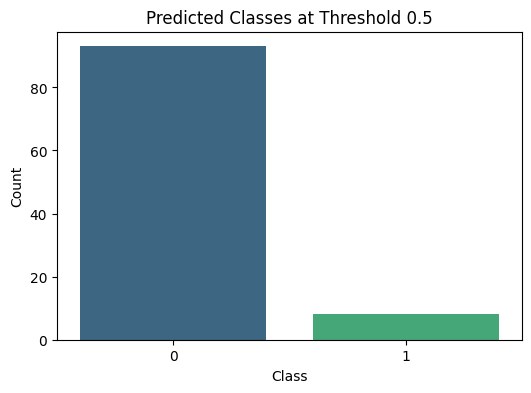

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of prediction probabilities
plt.figure(figsize=(8,5))
sns.histplot(df["prediction"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()

# Boxplot of predictions
plt.figure(figsize=(6,4))
sns.boxplot(x=df["prediction"], color="lightcoral")
plt.title("Boxplot of Predictions")
plt.show()

# Cumulative distribution
plt.figure(figsize=(8,5))
sns.ecdfplot(df["prediction"])
plt.title("Cumulative Distribution of Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Proportion")
plt.show()

# Thresholded predictions (say >0.5 = class 1, else 0)
df["predicted_class"] = (df["prediction"] > 0.5).astype(int)

plt.figure(figsize=(6,4))
sns.countplot(x=df["predicted_class"], palette="viridis")
plt.title("Predicted Classes at Threshold 0.5")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


# Your model

## Setup

In [ ]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

In [ ]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [ ]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: (arbitrary) The time step within each time series, which is regularly sampled

**Columns:**
- `value`: The values of the time series at each given time step
- `period`: whether you are in the first part of the time series (`0`), before the presumed break point, or in the second part (`1`), after the break point

In [ ]:
X_train

value  period
id    time                  
0     0     0.001858       0
      1    -0.001664       0
      2    -0.004386       0
      3     0.000699       0
      4    -0.002433       0
...              ...     ...
10000 1890 -0.005903       1
      1891  0.007295       1
      1892  0.003527       1
      1893  0.007218       1
      1894  0.000034       1

[23802099 rows x 2 columns]

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a time series id has a structural break, or not, from the presumed break point on.

**Index:**
- `id`: the ID of the time series

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [ ]:
y_train

id
0         True
1         True
2        False
3         True
4        False
         ...  
9996     False
9997      True
9998     False
9999     False
10000     True
Name: structural_breakpoint, Length: 10001, dtype: bool

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [ ]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [ ]:
X_test[0]

value  period
id    time                  
10001 0    -0.020657       0
      1    -0.005894       0
      2    -0.003052       0
      3    -0.000590       0
      4     0.009887       0
...              ...     ...
      2517  0.005084       1
      2518 -0.024414       1
      2519 -0.014986       1
      2520  0.012999       1
      2521 -0.022138       1

[2522 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)